## Import Libraries


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## Load the data


In [4]:
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2025-01-31'
data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Split the data into training and testing sets


In [5]:
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]


## Plot the closing prices


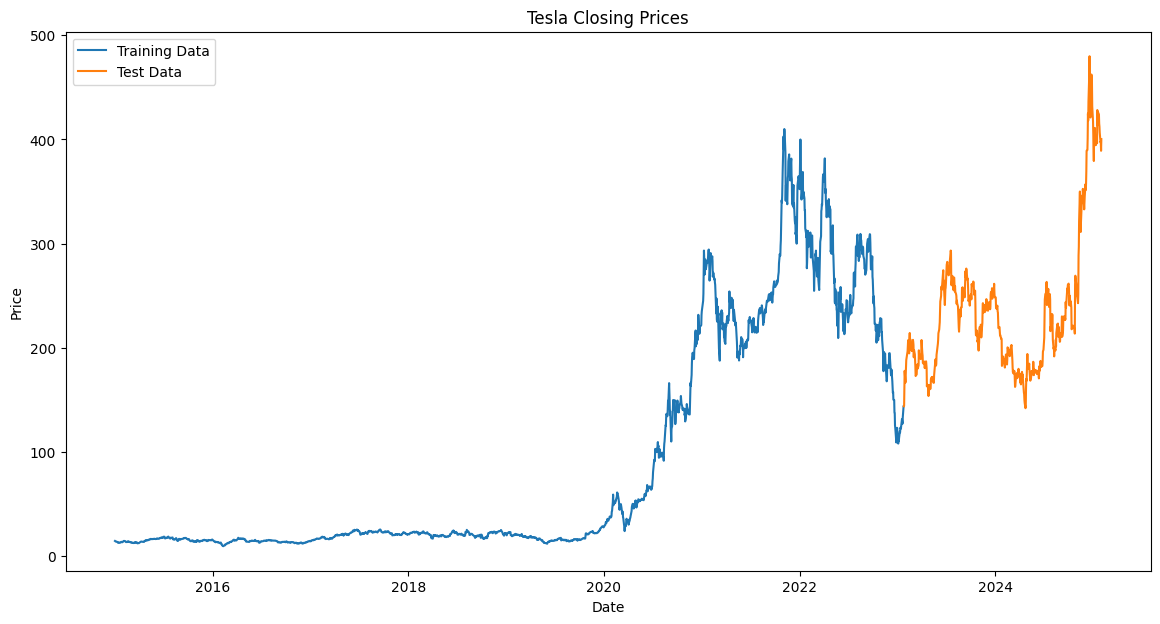

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.title('Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Train ARIMA Model

In [7]:
# Manually select ARIMA parameters (p, d, q)
p = 5
d = 1
q = 0

# Train the ARIMA model
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()

/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Forecast


In [8]:
arima_forecast = arima_model_fit.forecast(steps=len(test))


/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


* ##### Plot the forecast


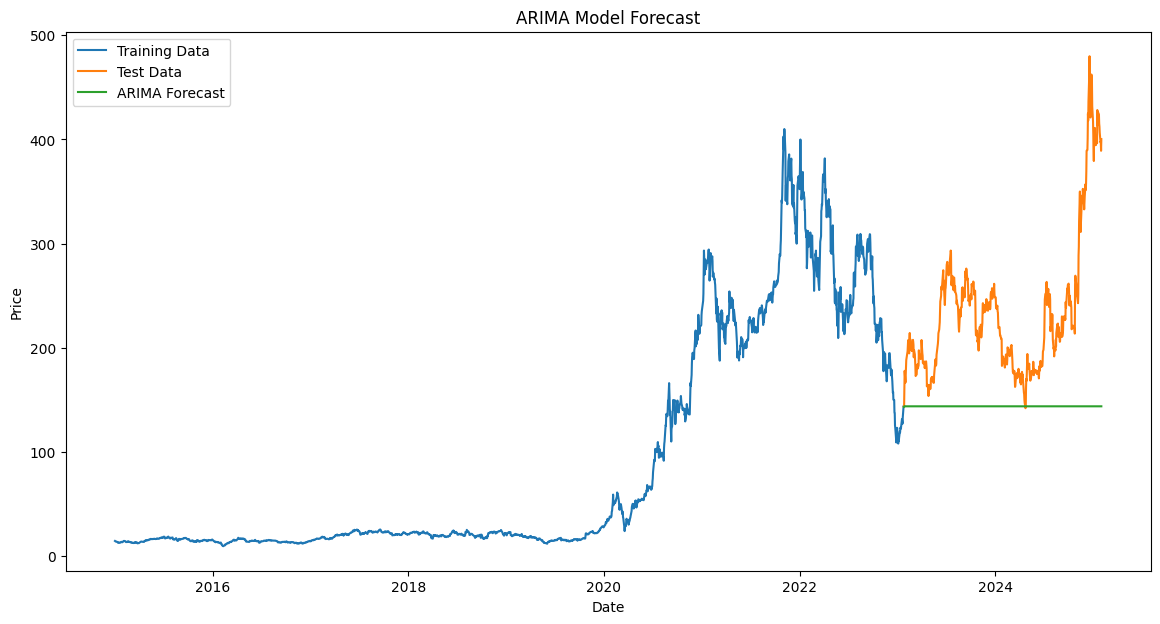

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


* ##### Calculate evaluation metrics


In [11]:
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print(f'ARIMA Model - MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}')


ARIMA Model - MAE: 89.80228002156842, RMSE: 110.98932205315383, MAPE: nan


## Train and Forecast with SARIMA Model

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train the SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)

/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


* #### Forecast with SARIMA Model


/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


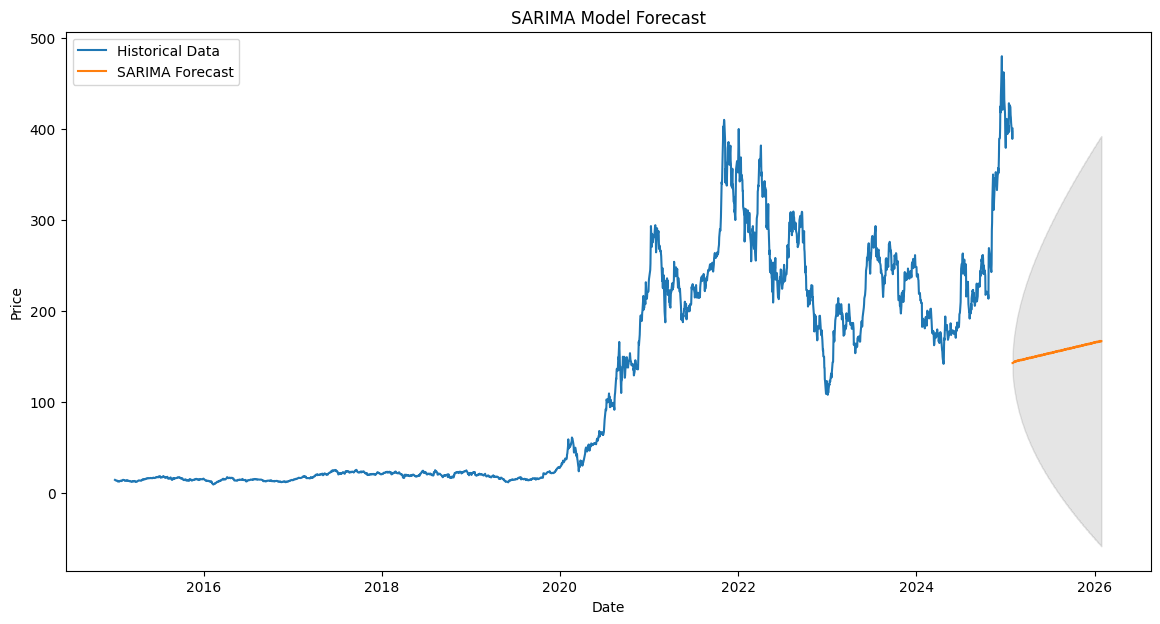

In [20]:
# Forecast for the next 12 months
sarima_forecast = sarima_model_fit.get_forecast(steps=365)
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(close_prices, label='Historical Data')
plt.plot(pd.date_range(start=test.index[-1], periods=365, freq='D'), sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(pd.date_range(start=test.index[-1], periods=365, freq='D'), sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
sarima_forecast_values = sarima_forecast.predicted_mean[:len(test[:365])]

# Slice the test set to match forecast length
test_subset = test[:365]

# Calculate Evaluation Metrics
sarima_mae = mean_absolute_error(test_subset, sarima_forecast_values)
sarima_rmse = np.sqrt(mean_squared_error(test_subset, sarima_forecast_values))

# Handle zero values in test data for MAPE
def calculate_mape(y_true, y_pred):
    # Convert to numpy arrays and flatten them
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    mask = y_true != 0
    # Calculate MAPE only for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



sarima_mape = calculate_mape(test_subset, sarima_forecast_values)


## LSTM Model

* #### Prepare Data for LSTM

In [12]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))

# Create training and testing datasets
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

* #### Build and Train LSTM Model

In [13]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-11/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0134
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0018
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0014
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0015
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0015
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0012
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0011
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0012
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0010
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 9.7314e-04
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.5221e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.9890e-04
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss:

* #### Forcast with LSTM Model

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


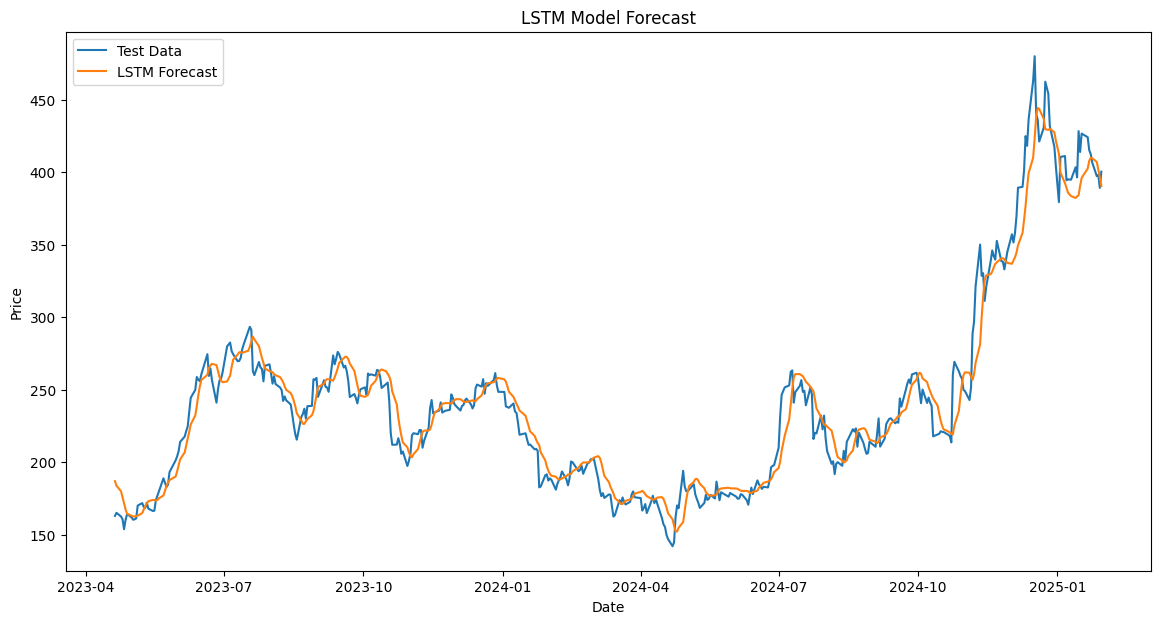

LSTM Model - MAE: 10.511222839355469, RMSE: 14.310603786608889, MAPE: 4.360390836799226


In [15]:
# Forecast
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index[train_size + seq_length:], test[seq_length:], label='Test Data')
plt.plot(close_prices.index[train_size + seq_length:], lstm_predictions, label='LSTM Forecast')
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
lstm_mae = mean_absolute_error(test[seq_length:], lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(test[seq_length:], lstm_predictions))
lstm_mape = np.mean(np.abs((test[seq_length:] - lstm_predictions) / test[seq_length:])) * 100

print(f'LSTM Model - MAE: {lstm_mae}, RMSE: {lstm_rmse}, MAPE: {lstm_mape}')

## Summary of Evaluation Metrics

In [30]:
print(f'ARIMA Model - MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}')
print(f'SARIMA Model - MAE: {sarima_mae}, RMSE: {sarima_rmse}, MAPE: {sarima_mape}')
print(f'LSTM Model - MAE: {lstm_mae}, RMSE: {lstm_rmse}, MAPE: {lstm_mape}')


ARIMA Model - MAE: 89.80228002156842, RMSE: 110.98932205315383, MAPE: nan
SARIMA Model - MAE: 55.24955918118005, RMSE: 66.47578994475569, MAPE: 24.110946161049018
LSTM Model - MAE: 10.511222839355469, RMSE: 14.310603786608889, MAPE: 4.360390836799226
